# CENG796 - Project Submission

This notebook includes working example of our implementation of Generative Flows with Invertible Attentions, and detailed info about the paper and relevant details.

##  Paper Abstract
Flow-based generative models have shown an excellent
ability to explicitly learn the probability density function
of data via a sequence of invertible transformations. Yet,
learning attentions in generative flows remains understudied, while it has made breakthroughs in other domains. To
fill the gap, this paper introduces two types of invertible attention mechanisms, i.e., map-based and transformer-based
attentions, for both unconditional and conditional generative flows. The key idea is to exploit a masked scheme of
these two attentions to learn long-range data dependencies
in the context of generative flows. The masked scheme allows for invertible attention modules with tractable Jacobian determinants, enabling its seamless integration at any
positions of the flow-based models. The proposed attention
mechanisms lead to more efficient generative flows, due to
their capability of modeling the long-term data dependencies. Evaluation on multiple image synthesis tasks shows
that the proposed attention flows result in efficient models
and compare favorably against the state-of-the-art unconditional and conditional generative flows.


##  Paper Summary
This paper aims to integrate the idea of attention in deep neural networks, to normalizing flow based models in order to enhance the performance of this class of generative models. This paper addresses the challenges, constraints for integrating attention to NF-based models and explains details of two proposed attention mechanisim named iMap and iTrans attention.
### Generative Flows
In the family of deep generative models there is a class called flow based models which optimizes exact log-likelihood and provides framework to compute probability densities explicitly. It learns computing the probability density function of the given data with sequence of invertible transformations. It starts with a simple distribution (e.g. Multivariate Gaussian), and transforms it to a complex distribution using change of variables formula for probability density functions. In existing normalizing flow based models feasibility of Jacobian determinant computation is considered, hence invertible transformations are choosen to have preferable Jacobian matrix structure. 
### Atention
In neural networks, naive convolutional layers have a problem of missing global dependencies in their inputs. In order to address this problem, attention mechanisms arrised. There are various techniques to impose attention to neural network models. There are two attention mechansims relevant to proposed solutions, map-based attention and transformers. In map based attention spatial attention maps are learned to scale features given by convolutional layers. Transformers integrates scaled dot product attention with its multi-head versions and it is defacto standart in many tasks in natural languae processing and achieves very high performance in vision tasks.
### IMAP
This paper introduces two attention mechanisms named IMAP and ITrans. IMAP stand for map based attention and we implemented it in our project. Map based attention scales feature map with learned attention weights.IMAP is an additional layer, and it is integrated to MARFlow architecture (Multiscale Autoregressive Priors) which is used as a backbone. Output of the attention layer and attention weights are computed using the following formula.

<p><img src="./img/h_out.PNG"></p>

<p><img src="./img/weights_imap.PNG"></p>

M is checkerboard mask, and output of G1 is computed with following formula, where M is checkerboard mask propoesd.
<p><img src="./img/G1.PNG"></p>
G2 is 1D convolutional layer, G3 applies average pooling to each channel dimensions, and G4 reorganizes (HxW) dimensional attention weights into (HxW)x(HxW) diagonal matrix. G5 corresponds to nonlinear activation functions. The overall computation graph can be seen in the following figure.
<p><img src="./img/Computation Graph.PNG"></p>

## Experiments

In [27]:
import torch
from __future__ import print_function
import argparse
import sys
import os
from tqdm import tqdm
import numpy as np
import math

import torch
import torch.nn as nn

import torch.utils.data
import torchvision.utils as vutils


import torch.optim as optim
import torch.optim.lr_scheduler as sched

import torchvision.datasets as dsets
import torchvision.transforms as transforms

from flow_modules.common_modules import Actnormlayer, InvertibleConv1x1, SqueezeLayer, Split2dMsC, TupleFlip
from flow_modules.affine_coupling import AffineCoupling
from flow_modules.mixlogcdf_coupling import MixLogCDFCoupling
from mar_prior.corr_prior import ChannelPriorMultiScale	
from imap import IMAP
from utils import get_dataset
from flow_modules.misc import ShiftTransform, MnistGlowTransform
from marscf_main import MarScfFlow, FlowNet, FlowStep, test_model, save_samples
## TODO further package imports

In [28]:
#Setting up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
#Setting up the hyperparameters
data_root = '../cifar_data'
dataset_name = "cifar10"
batch_size = 32

L = 3
K = 32
C = 64

epochs = 100
#Setting up the transforms for CIFAR10 Dataset
coupling_type = "affine"
setting_id = 'marscf_' + str(dataset_name) + '_' + str(coupling_type) + '_' + str(K) + '_' + str(C)
transform_train = transforms.Compose([ 
    ShiftTransform(3),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (1, 1, 1))])

transform_test = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1, 1, 1))])


In [30]:
#Train/Test DataLoaders
image_shape = [32,32,3]
trainset = dsets.CIFAR10(root=data_root, train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,drop_last=True,num_workers=2)

testset = dsets.CIFAR10(root=data_root, train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False,drop_last=True,num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
#model creation
mar_scf = MarScfFlow(batch_size, image_shape, coupling_type, L, K, C).to(device)

In [32]:
#optimizer and scheduler
optimizerG = optim.Adam(mar_scf.parameters(),lr=0.0008)
scheduler = sched.LambdaLR(optimizerG, lambda s: min(1., s / 10000))


In [ ]:
# Training and Test model in every 5 epocs
# Do NOT RUN!, IT TRAINS FOR 100 EPOCHS!
global_step = 0
for epoch in range(epochs):
    train_bar = tqdm(train_loader)
    for data in train_bar:
        optimizerG.zero_grad()
        data_im = data[0]
        if torch.cuda.is_available():
            data_im = data_im.cuda()
        z, nll, _ = mar_scf(data_im, reverse=False)
        loss = torch.mean(nll)
        loss = loss
        loss.backward()

        optimizerG.step()
        scheduler.step(global_step)
        global_step += batch_size

        train_bar.set_description('Train NLL (bits/dim) %.2f | Epoch %d -- Iteration ' % (loss.item(),epoch))

        if epoch % 5 == 0:

            tqdm.write('Evaluating model .... ')

            curr_test_nll = test_model( mar_scf, test_loader, 1)

            if not math.isnan(curr_test_nll):
                if curr_test_nll < best_test_nll:
                    torch.save(mar_scf.state_dict(), os.path.join('./checkpoints/', setting_id + '.pt'))
                    best_test_nll = curr_test_nll

            tqdm.write('Best Test NLL (bits/dim) at Epoch %d -- %.3f \n' % (epoch,best_test_nll))

In [33]:

#Sample Generation from best performed checkpoint
try:
    print(setting_id)
    state_dict = torch.load( os.path.join('./checkpoints/', setting_id +'.pt'))
    mar_scf.load_my_state_dict(state_dict)
    print('Checkpoint loaded!')
except Exception:
    print('Error loading checkpoint!')
    sys.exit(0)

print('Evaluating model on checkpoint .... ')
curr_test_nll = test_model( mar_scf, test_loader, 1)
print('Test NLL (bits/dim):  %.3f' % curr_test_nll)
save_samples( mar_scf, os.path.join('./samples/', setting_id + '.png'), samples=batch_size)


marscf_cifar10_affine_32_64
Checkpoint loaded!
Evaluating model on checkpoint .... 
Test NLL (bits/dim):  4.303


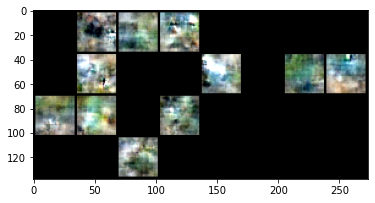

In [34]:
#Generated Samples Qualitative Results for CIFAR-10
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

generated_sample = mpimg.imread('./samples/marscf_cifar10_affine_32_64.png')
imgplot = plt.imshow(generated_sample)

 ### Quantitative Evaluation

 ### Challenges Encountered